In [18]:
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.transform import rowcol
from rasterio.windows import bounds as window_bounds
from rasterio.warp import transform_bounds
from pyproj import CRS, Transformer
import matplotlib.pyplot as plt
import folium
import os
import glob


In [19]:
dir_img = '/projects//my-private-bucket/HLS-1DCNN-AGB/data/tif/HLS_composites/monthly/br_af_grid60km_prj_evi2_max/vrt/'

exclude_bands = ['ValidMask.vrt', 'count.vrt', 'yearDate.vrt', 'JulianDate.vrt']

img_paths = glob.glob(os.path.join(dir_img, "*.vrt"))
img_paths = [
    f for f in img_paths
    if not any(f.endswith(ex) for ex in exclude_bands)
]

In [30]:

# --- config you can tweak ---
N_POINTS = 50          # how many points to sample
BUFFER_PIX = 64       # radius in pixels (window is ~ (2*BUFFER_PIX+1) squared)
BUFFER_METERS = None  # set a number (e.g., 60) to use metric buffer instead of pixel buffer


In [31]:
ref_year = 2022
ref_tile = 89
gpkg_points_path = f'/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/gedi/test/l4a_t90km_t{ref_tile}_veg{ref_year}_outrm.gpkg'

In [32]:

# Expect these to be defined
# gpkg_points_path = f'/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/gedi/test/l4a_t90km_t{ref_tile}_veg{ref_year}_outrm.gpkg'
# img_paths = ["/path/to/one.vrt", "/path/to/two.vrt", ...]

# --- read first N point geometries from gpkg ---
with fiona.open(gpkg_points_path, "r") as src:
    points_crs_fiona = src.crs  # fiona style dict or None
    points_list = []
    for i, feat in enumerate(src):
        geom = shape(feat["geometry"])
        if geom.geom_type != "Point":
            geom = geom.centroid
        points_list.append(geom)
        if len(points_list) >= N_POINTS:
            break

if len(points_list) == 0:
    raise ValueError("No point geometries found in the provided GPKG.")



In [33]:
# Convert fiona CRS dict to pyproj CRS if available
points_crs_pyproj = None
if points_crs_fiona:
    try:
        points_crs_pyproj = CRS.from_user_input(points_crs_fiona)
    except Exception:
        points_crs_pyproj = None

In [34]:
#
vrt_path = img_paths[0]  # you can change this index to explore another VRT
print("Using VRT:", vrt_path)

Using VRT: /projects//my-private-bucket/HLS-1DCNN-AGB/data/tif/HLS_composites/monthly/br_af_grid60km_prj_evi2_max/vrt/HLS.2018.01.maxevi2.Blue.vrt


In [35]:
with rasterio.open(vrt_path) as ds:
    ds_crs = CRS.from_user_input(ds.crs) if ds.crs is not None else None

    # Prepare transformer (points -> VRT CRS), if needed
    transformer_pts_to_ds = None
    if points_crs_pyproj is not None and ds_crs is not None and points_crs_pyproj != ds_crs:
        transformer_pts_to_ds = Transformer.from_crs(points_crs_pyproj, ds_crs, always_xy=True)

    # Reproject points to VRT CRS (or keep as-is if CRS matches/unknown)
    pts_ds = []
    for pt in points_list:
        if transformer_pts_to_ds is not None:
            x, y = transformer_pts_to_ds.transform(pt.x, pt.y)
            pts_ds.append((x, y))
        else:
            pts_ds.append((pt.x, pt.y))

    # Compute a window that covers all points with padding (in pixels)
    rows_cols = [rowcol(ds.transform, x, y) for (x, y) in pts_ds]
    rows = [rc[0] for rc in rows_cols]
    cols = [rc[1] for rc in rows_cols]

    pad = 128  # pixels of padding around the min/max point envelope
    r0 = max(0, min(rows) - pad)
    c0 = max(0, min(cols) - pad)
    r1 = min(ds.height, max(rows) + pad + 1)
    c1 = min(ds.width,  max(cols) + pad + 1)

    win = Window(col_off=c0, row_off=r0, width=c1 - c0, height=r1 - r0)

    # Read the first band for quick visualization
    arr = ds.read(1, window=win).astype(float)

    # Handle NoData for nicer plots
    nodata = ds.nodatavals[0]
    if nodata is not None:
        arr[arr == nodata] = np.nan

    # Normalize to 0-1 for plotting/export (ignore NaNs)
    finite = np.isfinite(arr)
    if finite.any():
        vmin, vmax = np.percentile(arr[finite], [2, 98])  # robust stretch
        arr_plot = np.clip((arr - vmin) / (vmax - vmin + 1e-9), 0, 1)
    else:
        arr_plot = arr  # all NaN, nothing to normalize

    # Window bounds in the raster CRS
    win_bounds = window_bounds(win, ds.transform)  # (minx, miny, maxx, maxy) in ds CRS


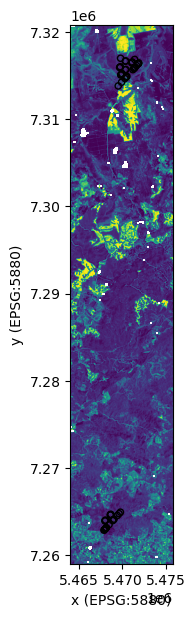

In [36]:
fig, ax = plt.subplots(figsize=(7, 7))
# Show using extent so axes reflect raster CRS coordinates
extent = (win_bounds[0], win_bounds[2], win_bounds[1], win_bounds[3])  # (minx, maxx, miny, maxy)
im = ax.imshow(arr_plot, extent=extent, origin="upper")
ax.set_xlabel(f"x ({ds_crs.to_string() if ds_crs else 'unknown CRS'})")
ax.set_ylabel(f"y ({ds_crs.to_string() if ds_crs else 'unknown CRS'})")

# Overlay points (in ds CRS)
xs_pts = [xy[0] for xy in pts_ds]
ys_pts = [xy[1] for xy in pts_ds]
ax.scatter(xs_pts, ys_pts, s=20, marker='o', edgecolor='black', facecolor='none', linewidth=1.0)
plt.show()


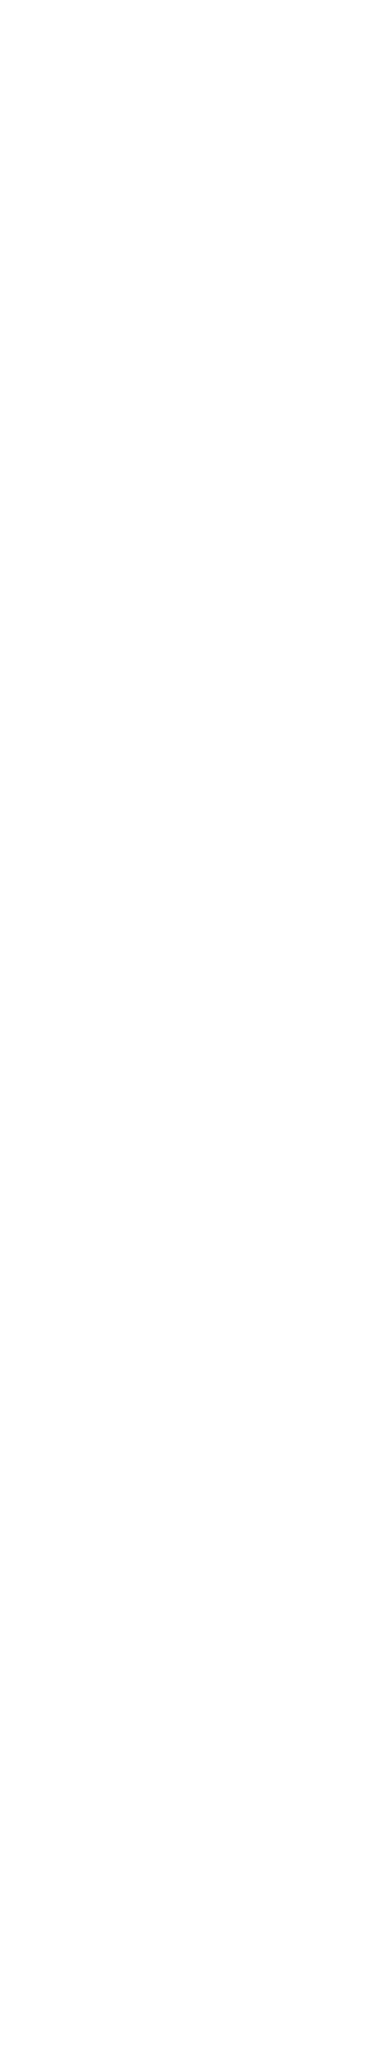

In [37]:
# Transform window bounds to EPSG:4326 for ImageOverlay
if ds_crs:
    win_bounds_wgs84 = transform_bounds(ds_crs, 4326, *win_bounds, densify_pts=21)
else:
    # Fallback: assume already lon/lat (not ideal)
    win_bounds_wgs84 = win_bounds

# Save the window as a PNG for the overlay
png_path = "vrt_window_preview.png"
plt.imsave(png_path, arr_plot, cmap="gray")

# Map center: use mean of points transformed to EPSG:4326
# Build transformer (ds CRS -> WGS84) if needed
transformer_ds_to_wgs84 = None
if ds_crs and ds_crs.to_epsg() != 4326:
    transformer_ds_to_wgs84 = Transformer.from_crs(ds_crs, 4326, always_xy=True)

lons_lats = []
for x, y in pts_ds:
    if transformer_ds_to_wgs84 is not None:
        lon, lat = transformer_ds_to_wgs84.transform(x, y)
    else:
        lon, lat = x, y
    lons_lats.append((lon, lat))

# If points are empty (shouldn't be), fall back to window center
if len(lons_lats) > 0:
    lon_c = np.mean([ll[0] for ll in lons_lats])
    lat_c = np.mean([ll[1] for ll in lons_lats])
else:
    lon_c = (win_bounds_wgs84[0] + win_bounds_wgs84[2]) / 2
    lat_c = (win_bounds_wgs84[1] + win_bounds_wgs84[3]) / 2

m = folium.Map(location=[lat_c, lon_c], zoom_start=13, tiles="OpenStreetMap")

# Add image overlay
south, west, north, east = win_bounds_wgs84[1], win_bounds_wgs84[0], win_bounds_wgs84[3], win_bounds_wgs84[2]
folium.raster_layers.ImageOverlay(
    name="VRT window",
    image=png_path,
    bounds=[[south, west], [north, east]],
    opacity=0.7,
    interactive=True,
    cross_origin=False
).add_to(m)

# Add the points as circle markers
for lon, lat in lons_lats:
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        color="red",
        fill=True,
        fill_opacity=0.9,
        popup=f"({lon:.6f}, {lat:.6f})"
    ).add_to(m)

folium.LayerControl().add_to(m)
m